In [455]:
#install dependencies
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import re
import pytesseract
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


In [11]:
#access site and search
initialUrl = "https://www.cacapava.sp.gov.br/pesquisar"
driver = webdriver.Chrome()
driver.get(initialUrl)
driver.maximize_window()
searchElement = driver.find_element("xpath", '//*[@id="busca"]')
searchElement.send_keys('Dengue')
searchElement.submit()


In [12]:
#get total of pages
htmlContent = driver.page_source
soup =  BeautifulSoup(htmlContent, 'html.parser')
options = soup.find_all('option')
totalOfPages = len(options)#21


In [13]:
#Crawling trhough the site and collect data
allItemImg =[]
for i in range(1, totalOfPages):
    htmlContent = driver.page_source
    soup =  BeautifulSoup(htmlContent, 'html.parser')
    itemImg = soup.find_all('a', class_='list-image')
    allItemImg.extend(itemImg)
    xpath = f'//*[@id="conteudo"]/section/div/nav/div[2]/select/option[{i+1}]'
    nextPage = driver.find_element("xpath", xpath)
    nextPage.click()

In [14]:
#filter data
convertedArr =[str(item) for item in allItemImg]
filteredArr = []
for item in convertedArr:
    if re.search(r'boletim', item) and re.search(r'2023', item) and not re.search(r'corona', item):
        match = re.search(r'url\((.*?)\)', item)
        if match:
            url = match.group(1)
            filteredArr.append(url)
           

In [15]:
#download all imgs
arrOfImgName = []
for i in range(0 ,len(filteredArr)):
    arrOfImgName.append('img{}.png'.format(i))
    downloadedData = requests.get(filteredArr[i])
    with open(r'C:\Users\Marina\Desktop\Dengue\imgs\img{}.png'.format(i), 'wb') as f:
        f.write(downloadedData.content)

In [16]:
#read all images
arrOfData = []
arrOfFilteredData = []
for i in range(0, len(arrOfImgName)):
    path = "C:\Program Files\Tesseract-OCR"
    img = cv2.imread(r'C:\Users\Marina\Desktop\Dengue\imgs\img{}.png'.format(len(arrOfImgName)-1-i))
    pytesseract.pytesseract.tesseract_cmd = path + r"\tesseract.exe"
    txt = pytesseract.image_to_string(img)
    rgx1 = re.sub(r'\(.*?\)', ' ', txt).replace('2023', '').replace(']', '1').replace('\n', '').replace('Q', '9').replace('O', '0')
    rgx2 = re.sub(r"(?<=\s\d{2})/", "7", rgx1)
    refactorText =  re.sub(r'\D+', ' ', rgx2).strip().split()
    if (i>0 and  int(arrOfData[i-1][3]) > int(refactorText[3])) :
       conct2 = refactorText[3] + refactorText[4]
       refactorText[3] = conct2
       del refactorText[4]
    if (i>0 and int(arrOfData[i-1][4]) > int(refactorText[4])) :
       conct1 = refactorText[4] + refactorText[5]
       refactorText[4] = conct1
       del refactorText[5]
    if(int(refactorText[0]) > 6):
      refactorText.insert(0,'0')
    for x in range(len(refactorText) - 1, 3, -1):
      if refactorText[x] == '00':
        refactorText.remove('00')
    arrOfData.append(refactorText)
    arrOfFilteredData.append(refactorText[2:5])



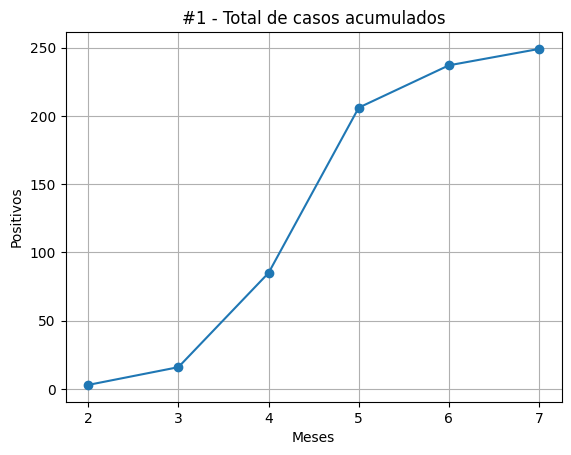

In [729]:
#total of cases
finalData = pd.DataFrame(arrOfFilteredData, columns=['Meses', 'Positivos', 'Autoctones'])
finalData['Positivos'] = pd.to_numeric(finalData['Positivos'])
finalData['Autoctones'] = pd.to_numeric(finalData['Autoctones'])
finalData['Meses'] = pd.to_numeric(finalData['Meses'])
finalData['Externos'] = finalData['Positivos'] - finalData['Autoctones']
groudpedData = finalData.groupby('Meses').max()
months = groudpedData.index
groudpedData = groudpedData.reset_index()
groudpedData['Meses'] = months
plt.plot(groudpedData['Meses'], groudpedData['Positivos'], 'o-')
plt.xlabel('Meses')
plt.ylabel('Positivos')
plt.title('#1 - Total de casos acumulados')
plt.grid(True)
plt.show()


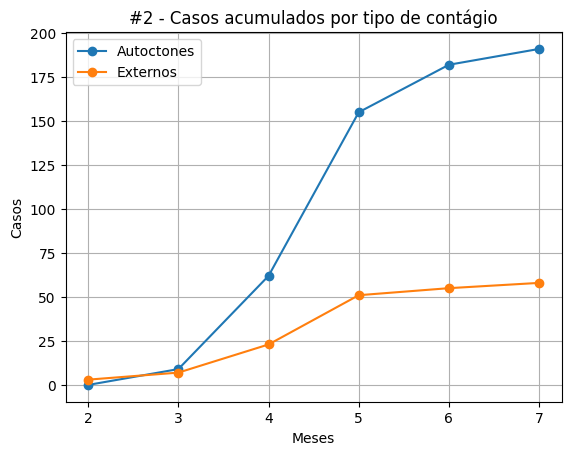

In [541]:
#types of Contagion accumulated
plt.plot(groudpedData['Meses'], groudpedData[['Autoctones', 'Externos']], 'o-')
plt.xlabel('Meses')
plt.ylabel('Casos')
plt.title('#2 - Casos acumulados por tipo de contágio')
plt.grid(True)
plt.legend(['Autoctones', 'Externos'])
plt.show()


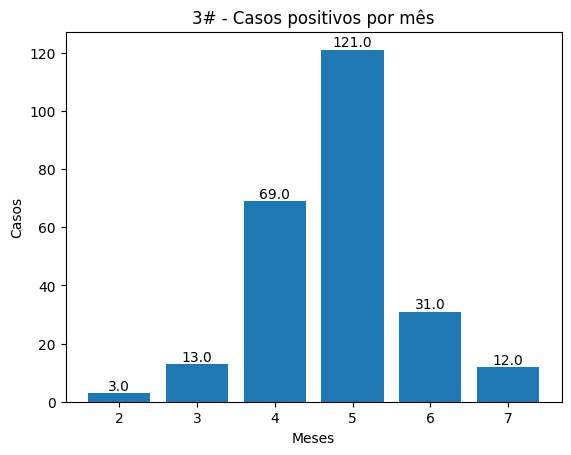

In [730]:
#Positives by Month
postivesCasesByMonth = groudpedData['Positivos'].iloc[0:].diff().fillna(groudpedData['Positivos'][0])
postivesAutoctonesByMonth = groudpedData['Autoctones'].iloc[0:].diff().fillna(groudpedData['Autoctones'][0])
positvesExternalByMonth = groudpedData['Externos'].iloc[0:].diff().fillna(groudpedData['Externos'][0])
graphPositivesByMonths = pd.DataFrame()
graphPositivesByMonths['Meses'] = months
graphPositivesByMonths['Casos'] = postivesCasesByMonth
plt.bar(graphPositivesByMonths['Meses'], graphPositivesByMonths['Casos'])
for x, y in zip(graphPositivesByMonths['Meses'], graphPositivesByMonths['Casos']):
    plt.text(x, y, str(y), ha='center', va='bottom')
plt.xlabel('Meses')
plt.ylabel('Casos')
plt.title('3# - Casos positivos por mês')

plt.show()

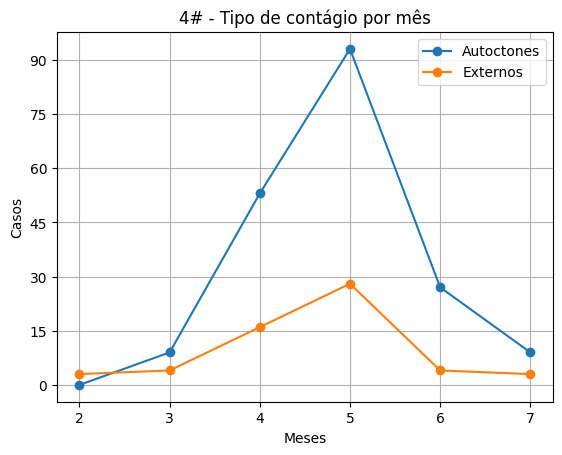

In [731]:
#type of contagions by months
graphContagionsByMonths = pd.DataFrame()
graphContagionsByMonths['Meses'] = months
graphContagionsByMonths['Autoctones'] = postivesAutoctonesByMonth
graphContagionsByMonths['Externos'] = positvesExternalByMonth

plt.yticks(range(0, 150, 15))
plt.plot(graphContagionsByMonths['Meses'], graphContagionsByMonths['Autoctones'], 'o-', label='Autoctones')
plt.plot(graphContagionsByMonths['Meses'], graphContagionsByMonths['Externos'], 'o-', label='Externos')
plt.xlabel('Meses')
plt.ylabel('Casos')
plt.title('4# - Tipo de contágio por mês')
plt.legend()

plt.grid(True)
plt.show()

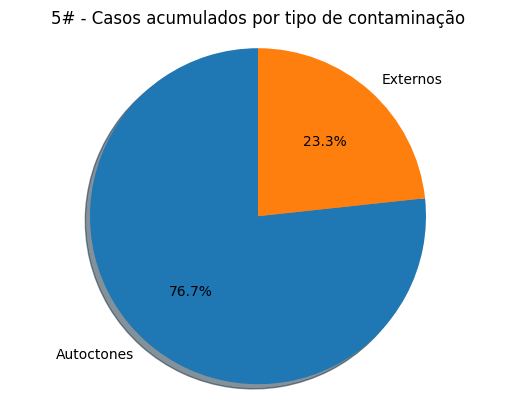

In [732]:
#percetage statistics graph
totalCases = groudpedData['Positivos'].iloc[-1]
totalExternalCases = groudpedData['Externos'].iloc[-1]
totalAutoctonesCases = groudpedData['Autoctones'].iloc[-1]
percetageAutoctones = (totalAutoctonesCases / totalCases ) *100
percetageExternal  = ( totalExternalCases / totalCases) * 100

plt.pie([percetageAutoctones, percetageExternal], labels=['Autoctones', 'Externos'], autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal') 
plt.title('5# - Casos acumulados por tipo de contaminação')

plt.show()

In [776]:
increaseByMonth = pd.DataFrame()
increaseByMonth = graphPositivesByMonths


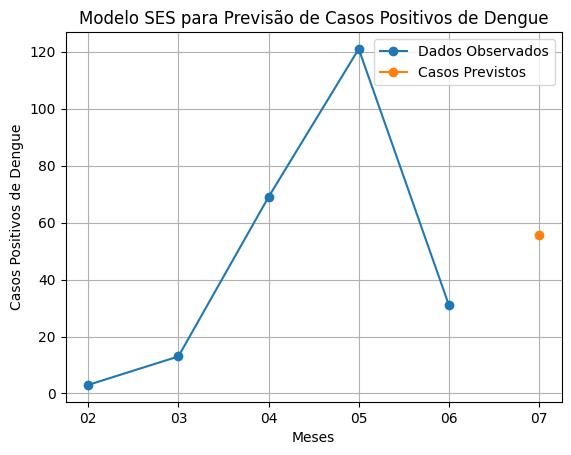

In [588]:
#suavização exponencial simples (SES)
#It is a forecasting method that assigns greater weight to more recent values and progressively decreases the weight for earlier values.
# Indicated for cases where the series does not exhibit a clear trend or seasonal pattern
#Dengue has many factors, such as rainfall, climate, public policy, and population

data = graphPositivesByMonths.iloc[:-1].copy()
data['Meses'] = pd.to_datetime(data['Meses'], format='%m')
data.set_index('Meses', inplace=True)
data.index.freq = 'MS'
#creating model
sesModel = SimpleExpSmoothing(data)
#adjust model
sesResult = sesModel.fit()
#doing predictions
forecast = sesResult.forecast(1) #55
# See results
plt.plot(data.index.strftime('%m'), data, label='Dados Observados', marker='o')
plt.plot(forecast.index.strftime('%m'), forecast, label='Casos Previstos', marker='o',  linestyle='-')
plt.xlabel('Meses')
plt.ylabel('Casos Positivos de Dengue')
plt.title('Modelo SES para Previsão de Casos Positivos de Dengue')
plt.legend()
plt.grid(True)
plt.show()

